In [1]:
import pandas as pd
import csv
import re
import warnings
import time 
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')

In [2]:
file = "big_df_v2.csv"  #large file for production
#file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [3]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [4]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           247144
parentItemId      3974
itemId            3515
shortDn            204
main_cat             0
sub_cat              0
catNode              0
longDn               0
categoryPath         0
name                 0
dtype: int64

In [5]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 74 categories of books.
56 categories have more than 100 books.


In [6]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

# Print number of titles represented in each of the Top 40 categories #
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [7]:
# Only keep records for top n populated categories (drop sparsely populated categories) #
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [8]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [9]:
#!pip install gensim

In [10]:
import numpy as np
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Fancy LDA visualization tool
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable gensim logging 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])
#stop_words.extend(['book', 'new']) # decided extra stop words could be introducing bias 

In [12]:
# reviewing unique categories #
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Literature & Fiction Books'
 'Religion & Spirituality Books' 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Teen & Young Adult Books' 'Medical Books'
 'Self-Help Books' 'History Books' 'True Crime Books'
 'Psychology & Social Science Books' 'House, Home & Gardening Books'
 'Travel Books' 'Education Books' 'Engineering & Transportation Books'
 'Science & Nature Books' 'Language Arts & Disciplines Books' 'Law Books'
 'Foreign Language Study & Reference Books' 'Mathematics Books'
 'Political Books' 'Philosophy Books' 'Sports & Outdoor Books'
 'Language Arts & Disciplines' 'Business & Money' 'Nonfiction' 'History'
 'Law']


In [13]:
data = df.longDn.values.tolist()

In [14]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence 

In [15]:
# random check to ensure clean data
data[300]

'Robust DC Comics Roster Engage in epic match ups with a massive roster of DC Comics heroes and villains including Batman Cyborg The Flash Harley Quinn Nightwing Solomon Grundy Superman and Wonder Woman Master God Like Powers Unleash each character s unique super powers with individual move sets and environmental interactions Uncontainable Battles Fight through multi tiered fighting arenas by hurling opponents through buildings and launching them off cliffs Original DC Comics Saga Set in Iconic Environments Experience an authentic DC Comics storyline created in collaboration between NetherRealm Studios DC Entertainment and writers Justin Gray and Jimmy Palmiotti Players will discover and do battle in numerous iconic locales pulled from DC Comics lore Destructive Fighter in which the World is a Weapon Experience epic battles on a massive scale as players control the most powerful beings in the universe in destructible interactive environments Destroy elements of the world and use super 

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [17]:
# Build the bigrams and trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [19]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])


C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\Users\BS\Anaconda3\lib\site-packages\msgpack_

C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\Users\BS\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


In [20]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [21]:
final_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)


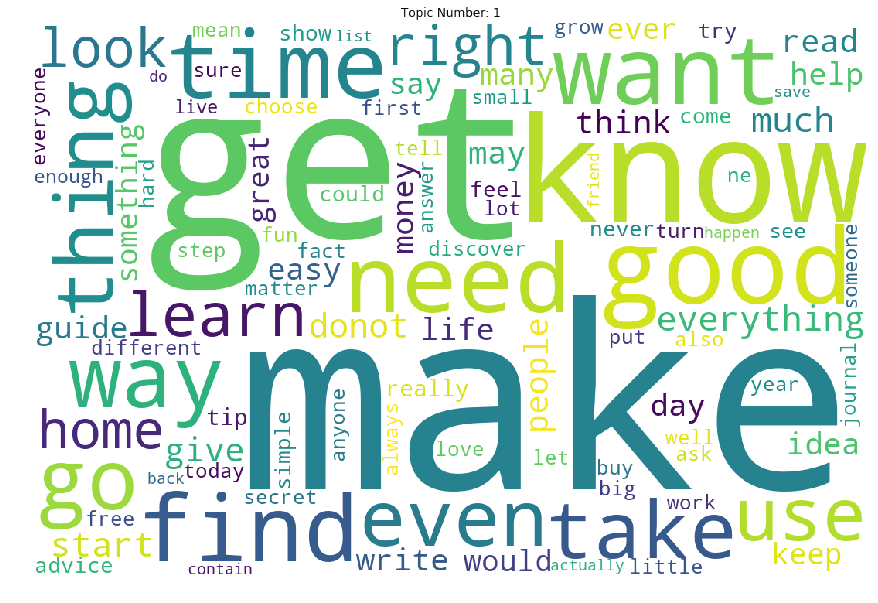

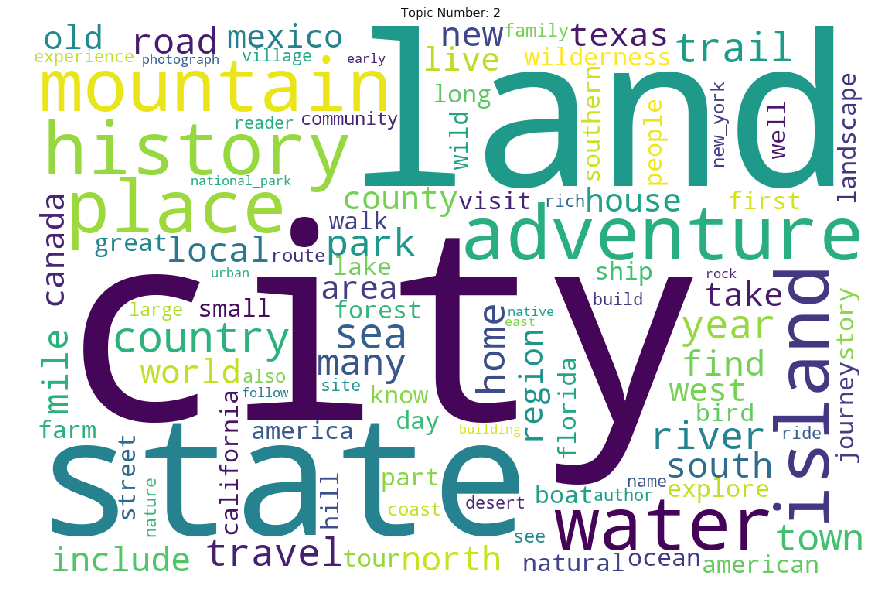

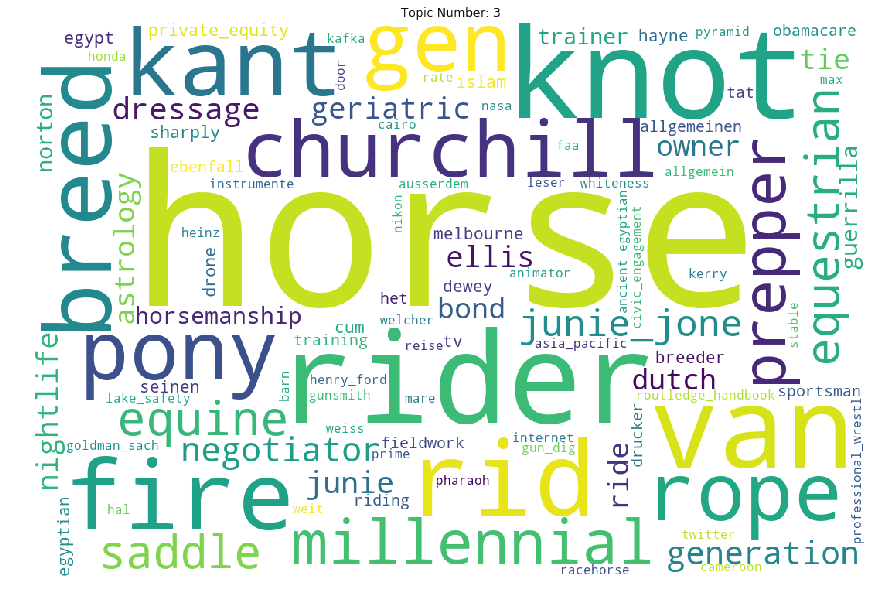

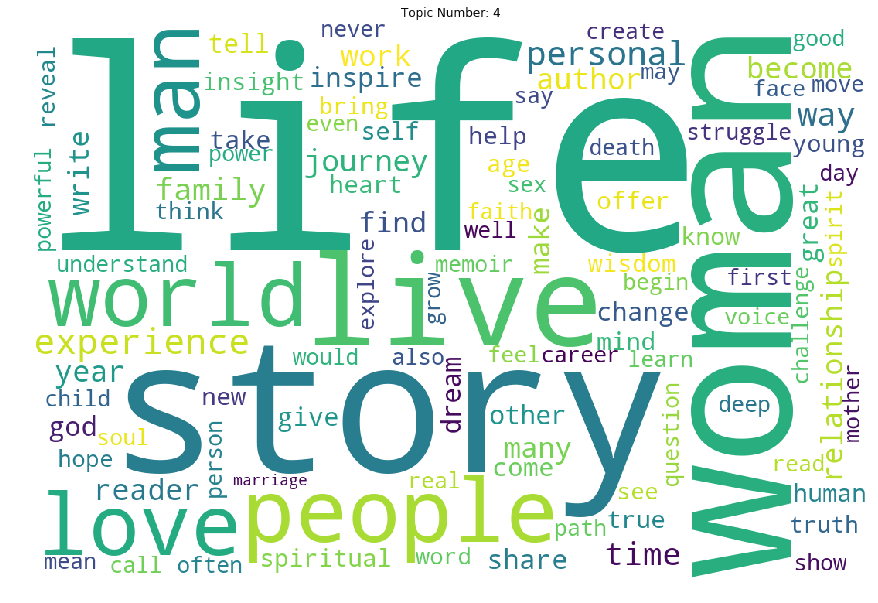

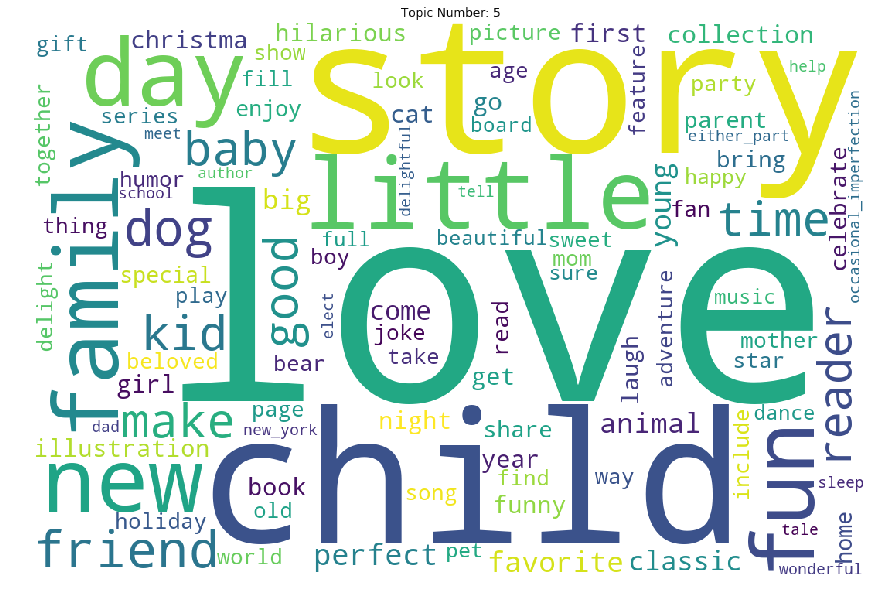

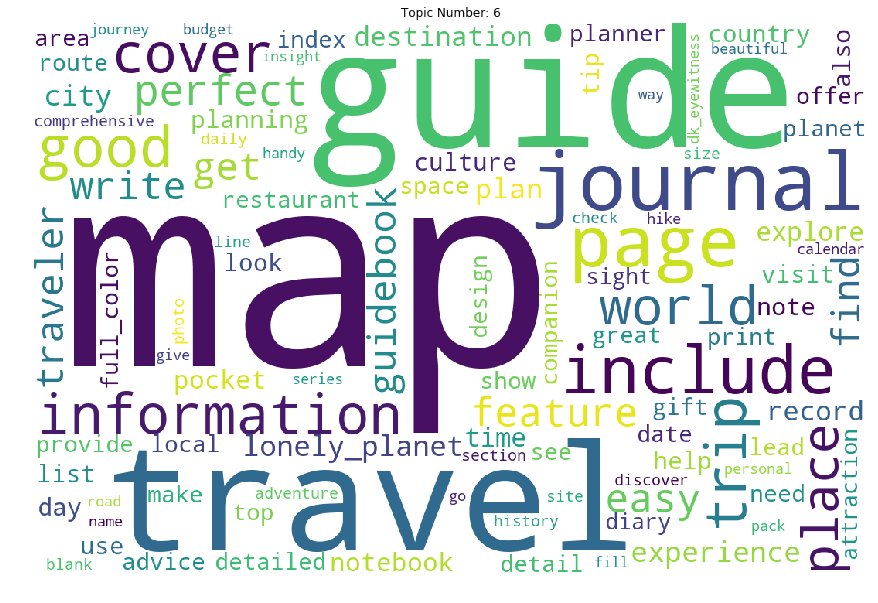

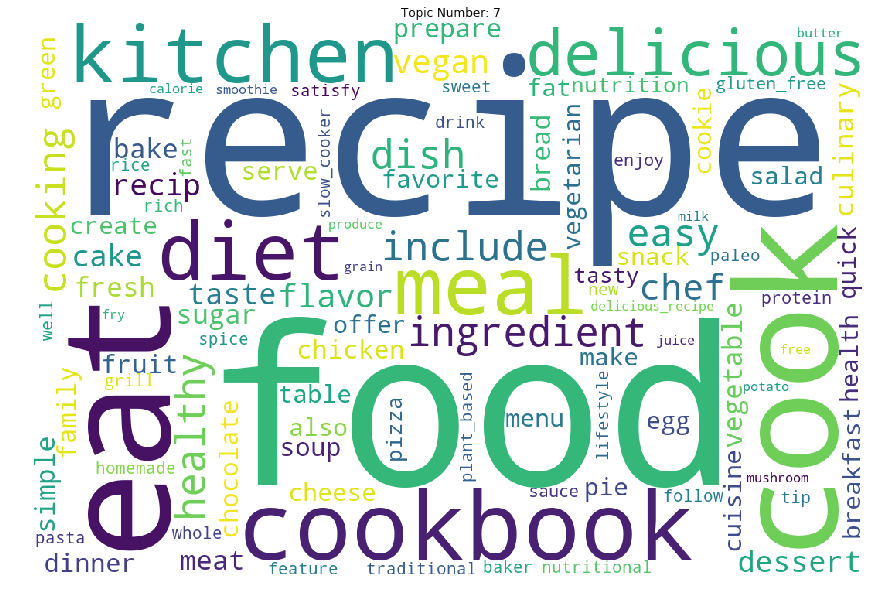

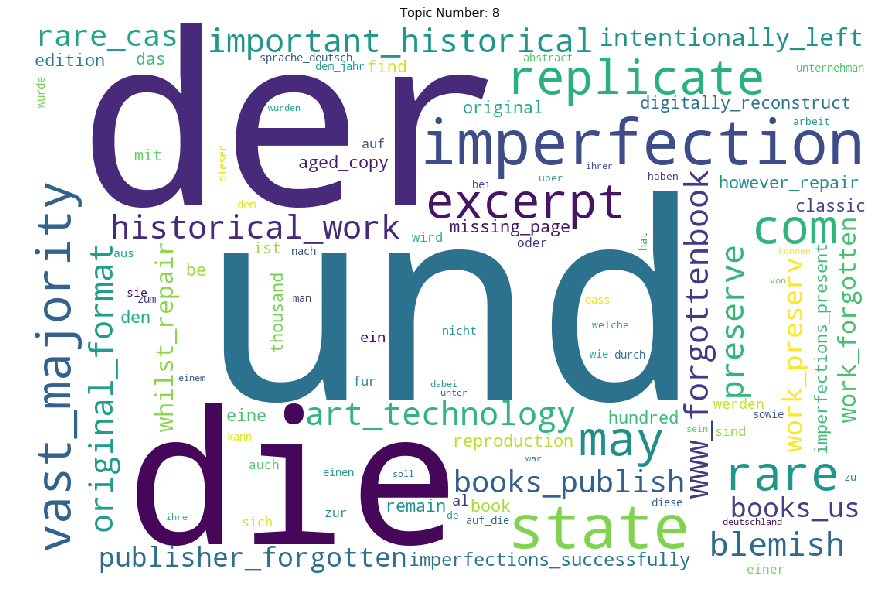

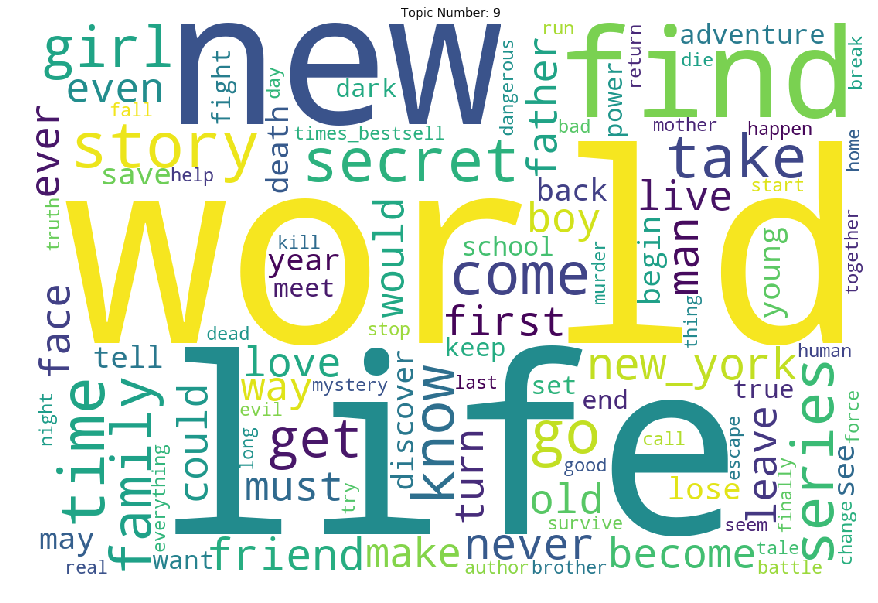

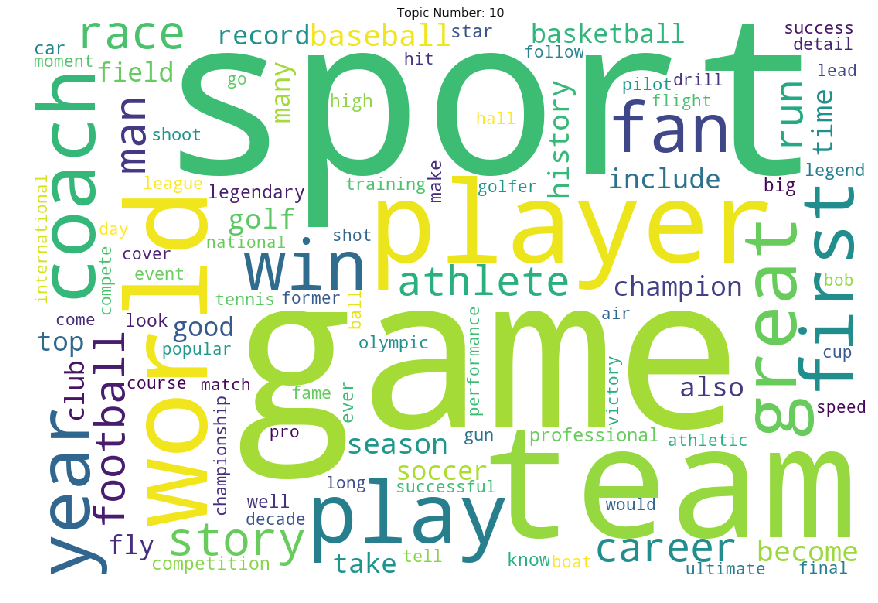

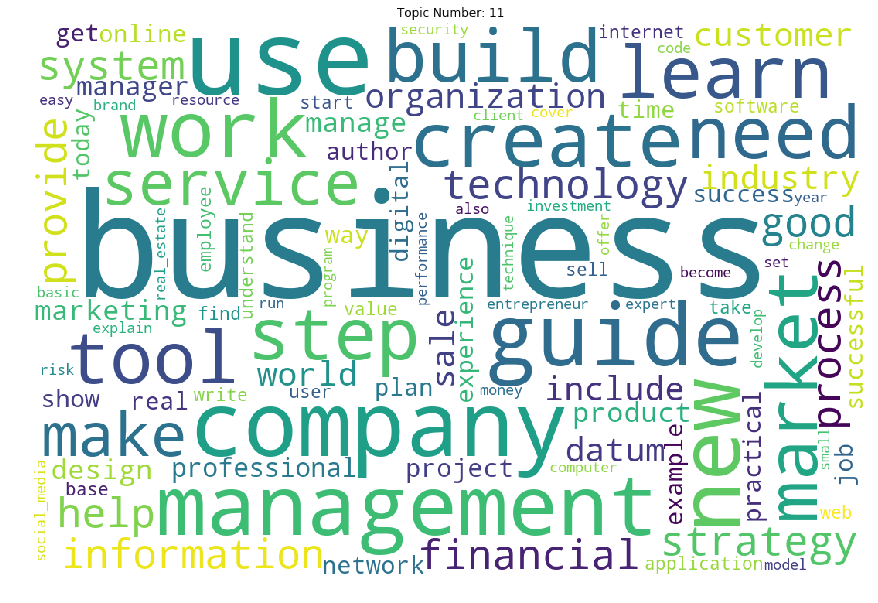

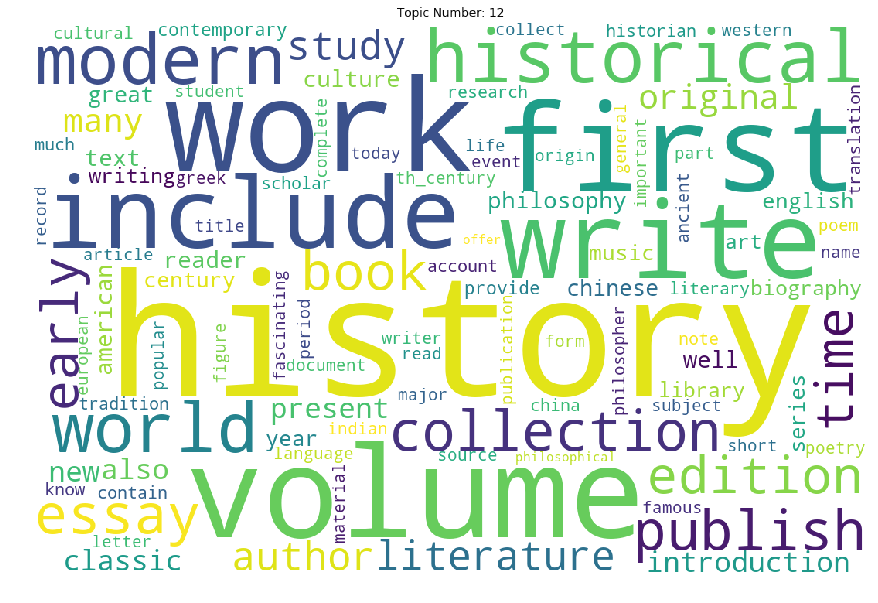

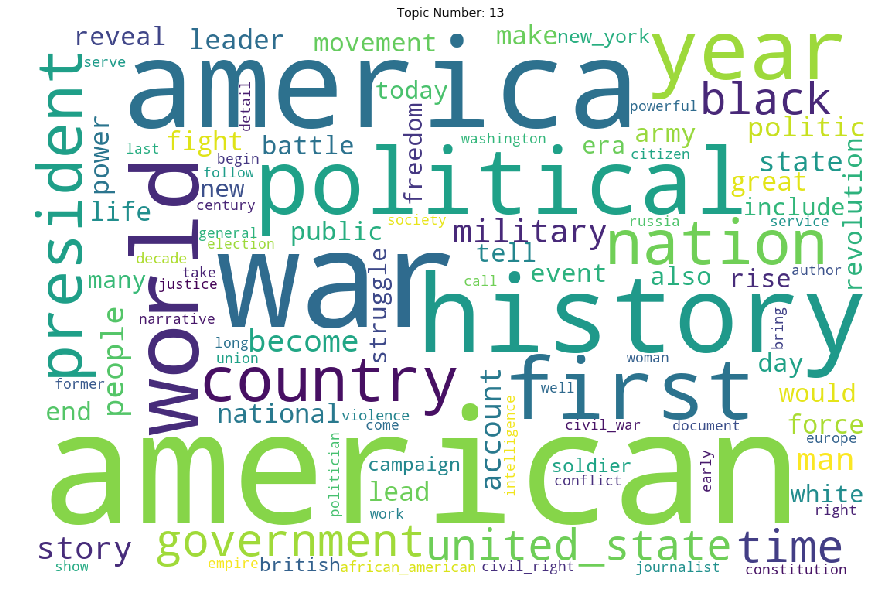

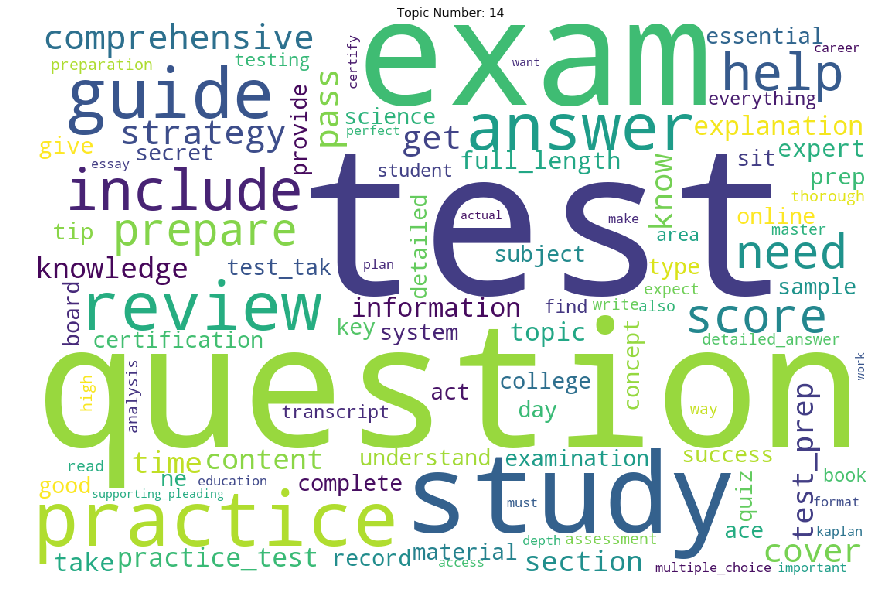

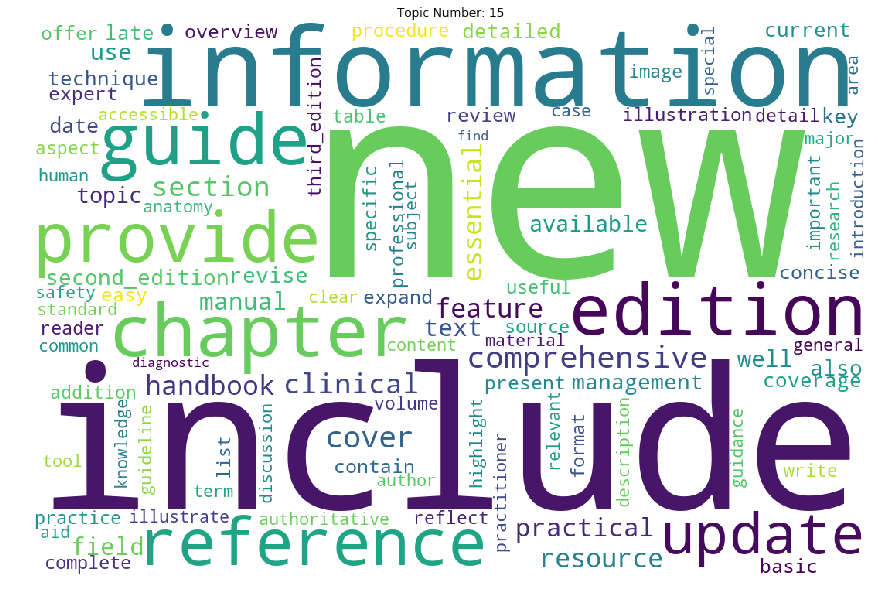

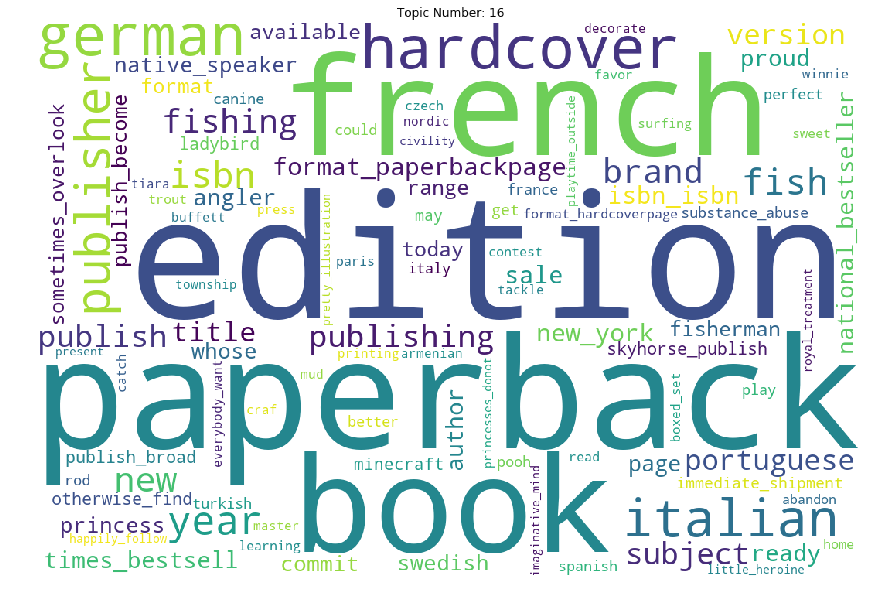

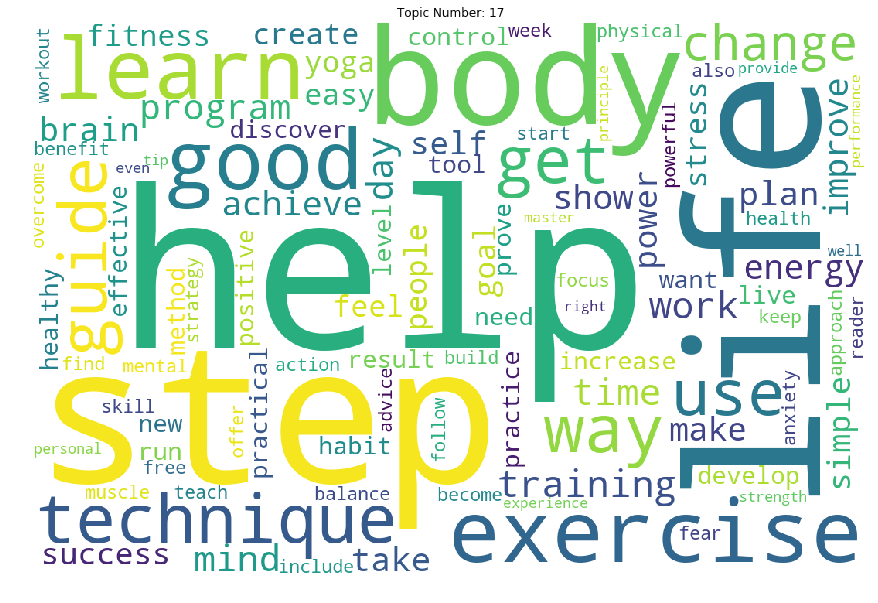

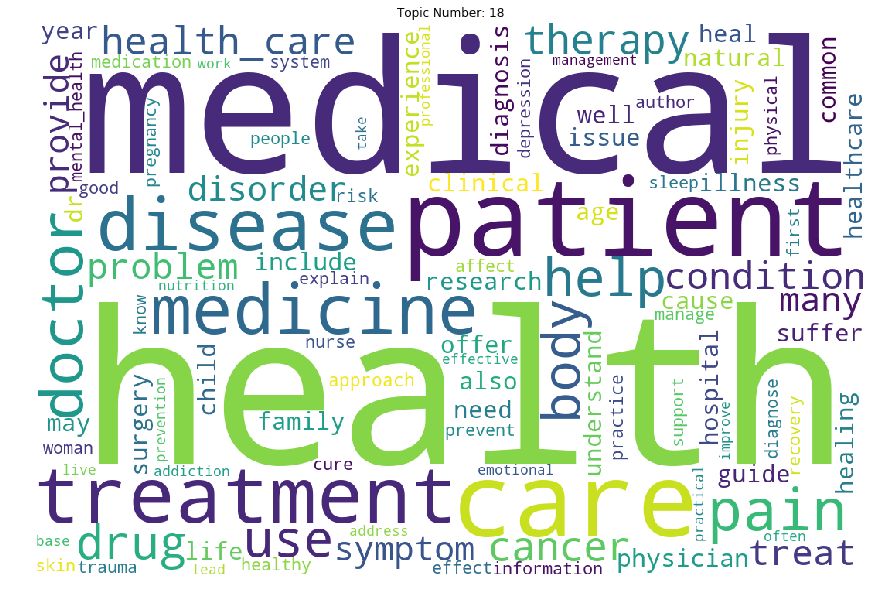

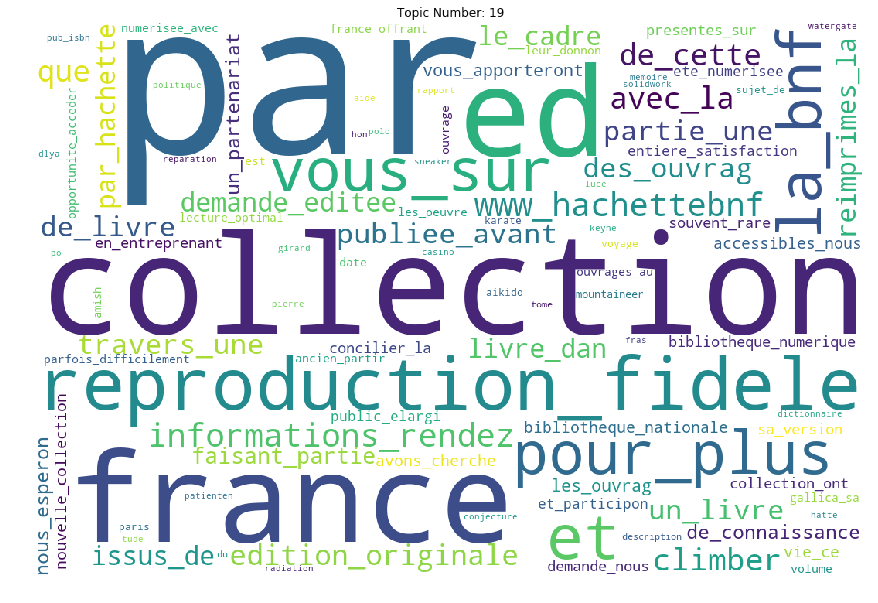

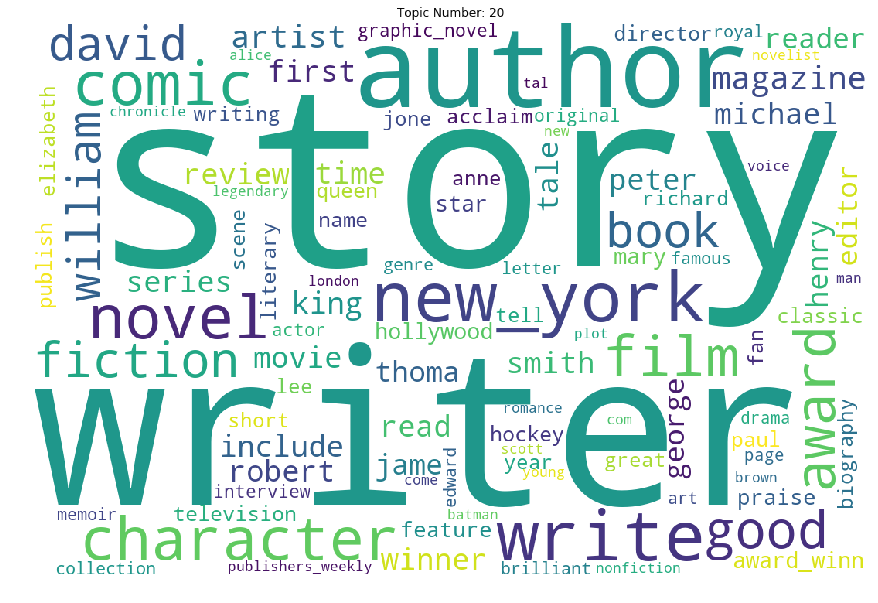

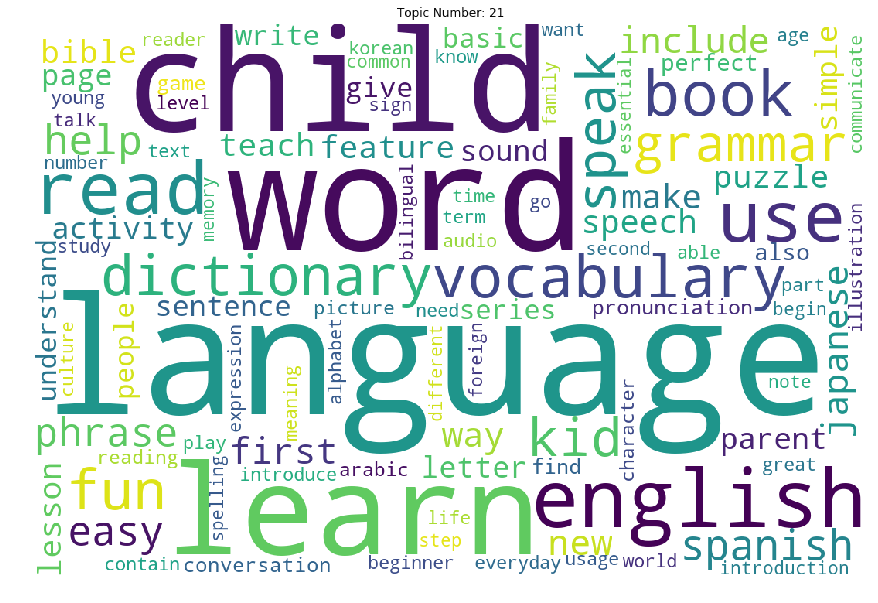

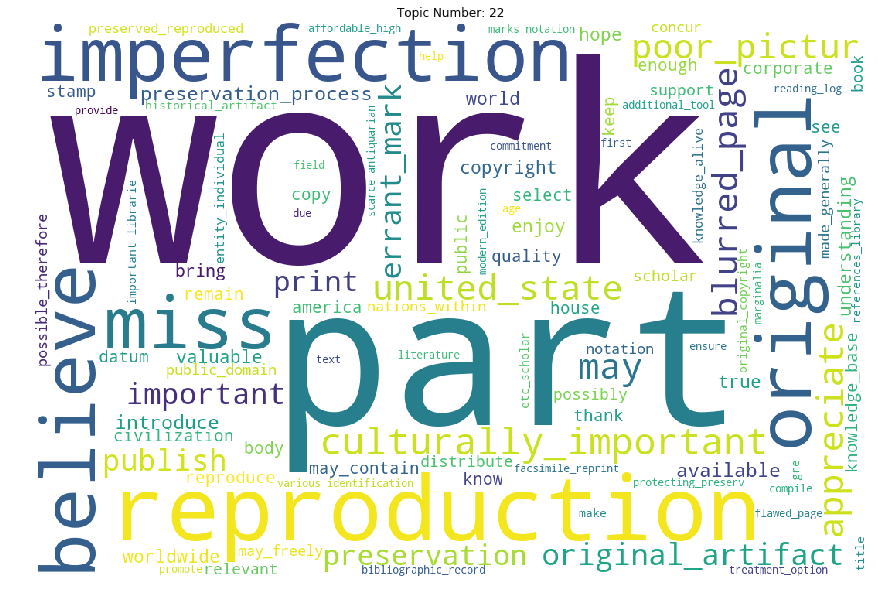

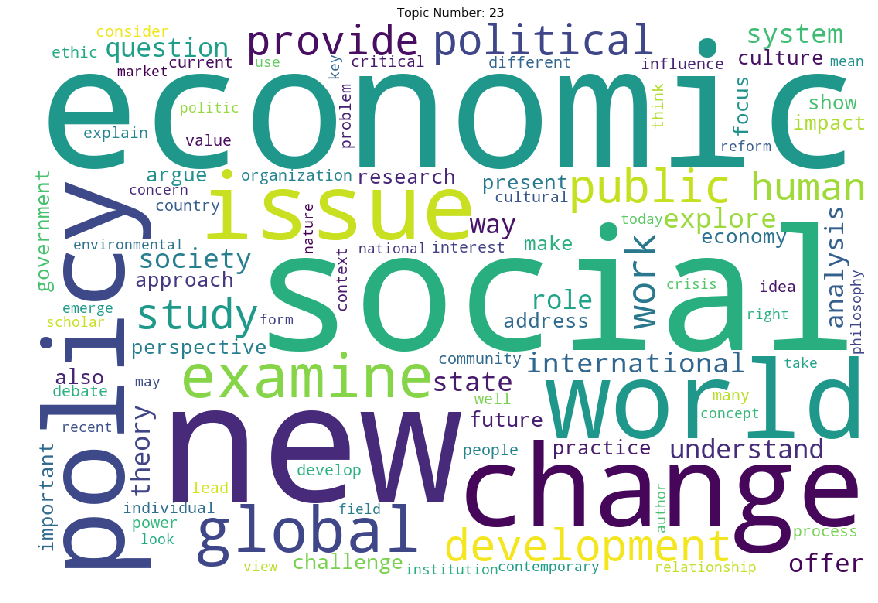

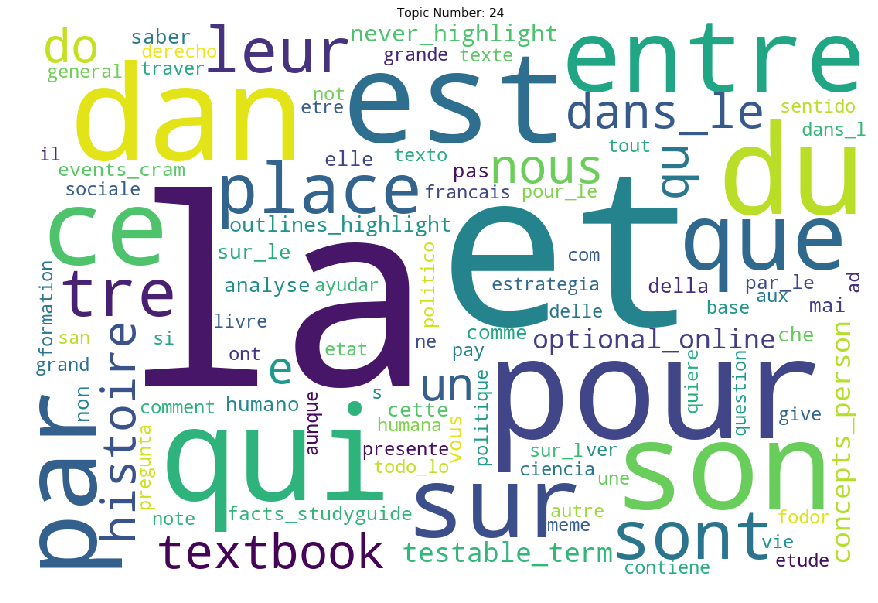

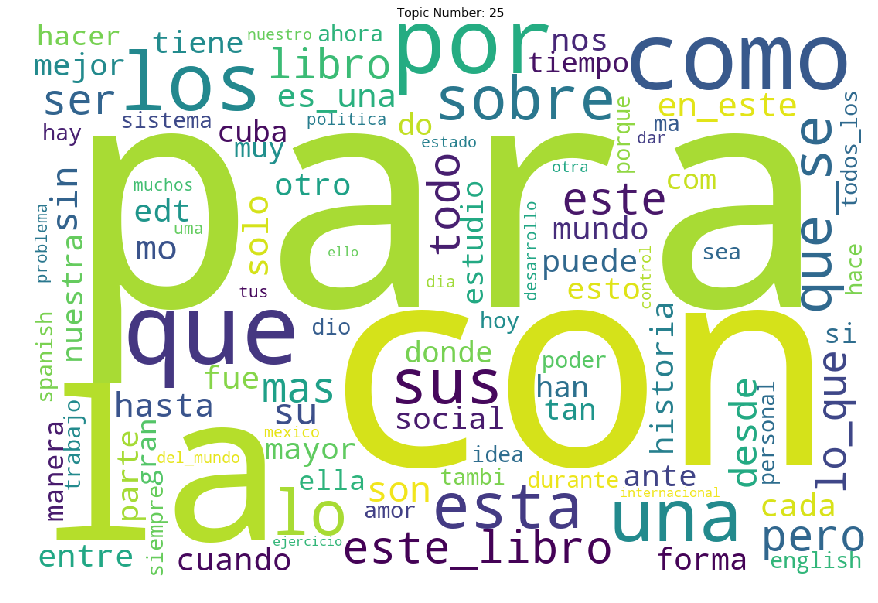

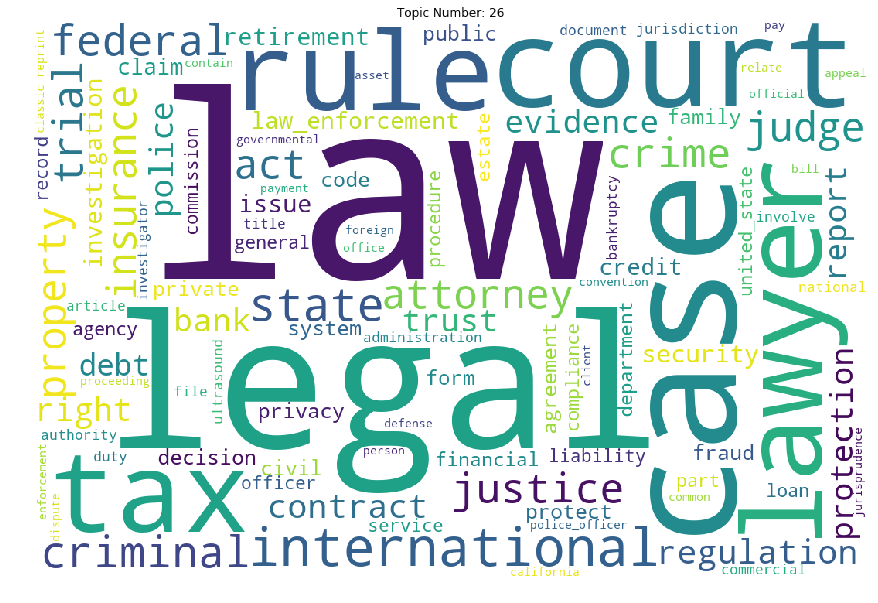

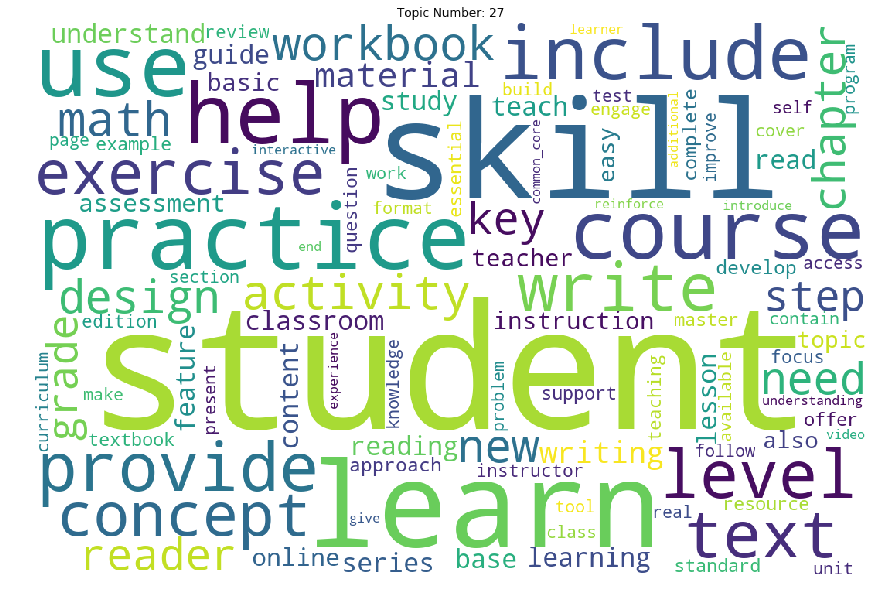

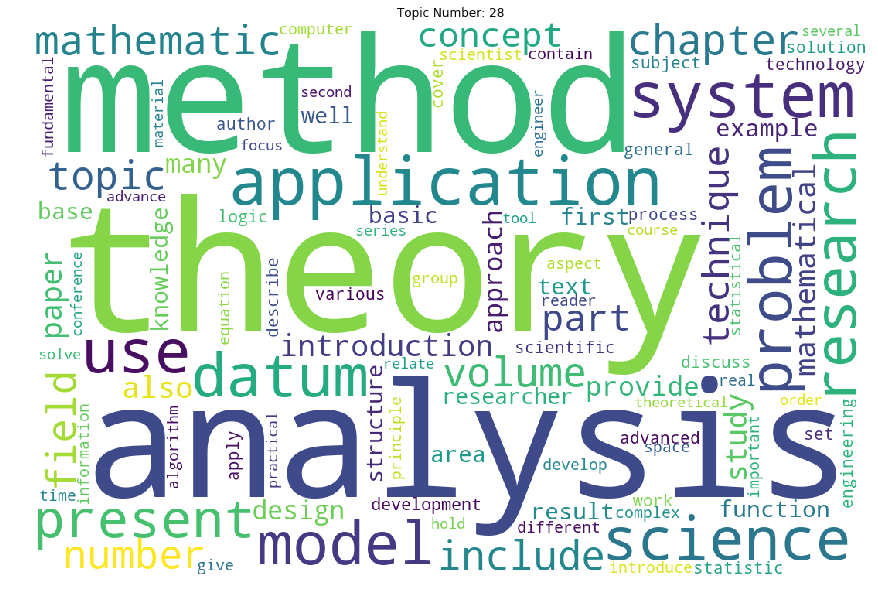

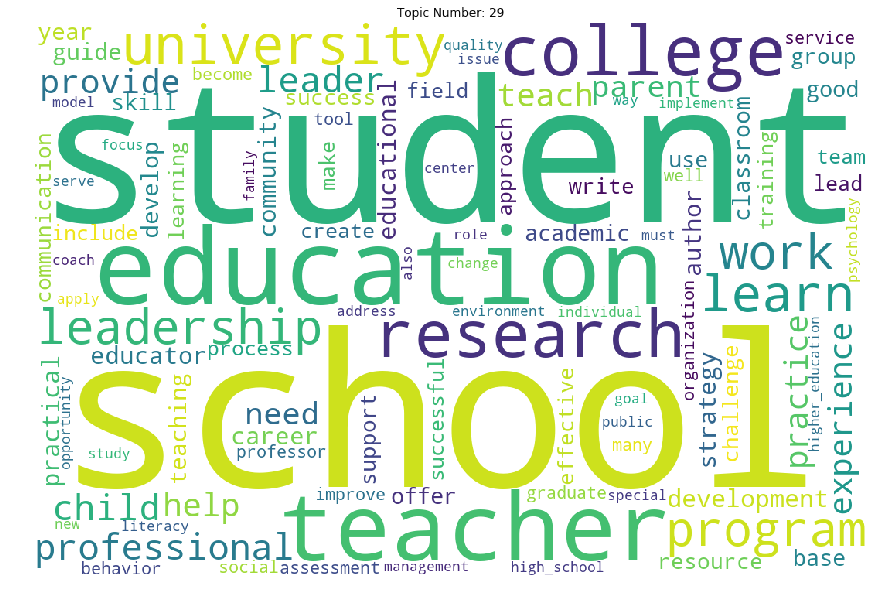

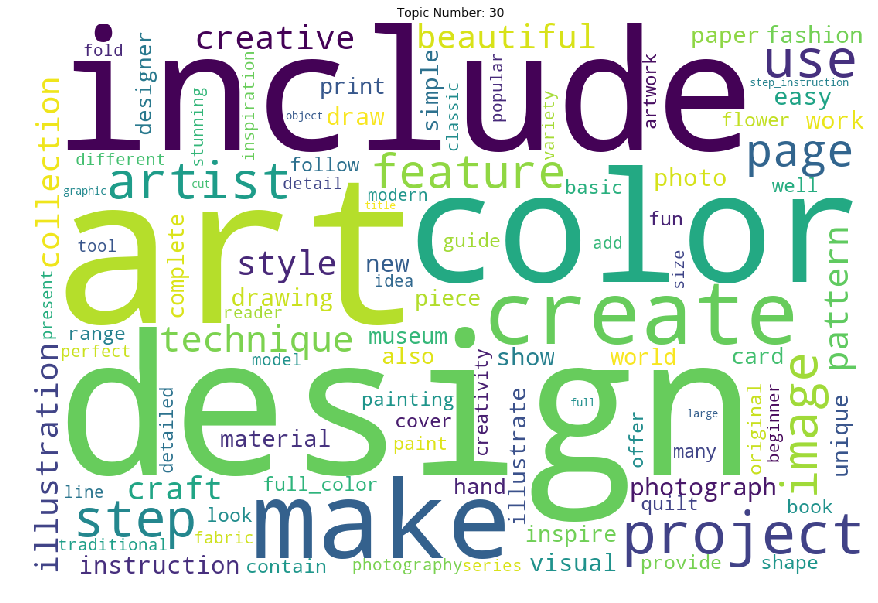

In [22]:
for topic in range(final_lda_model.num_topics):
    plt.figure(figsize=(12,10))
    #defining 1080x720 dimensions improved text clarity.
    plt.imshow(WordCloud(background_color='white',width=1080, height=720).fit_words(dict(final_lda_model.show_topic(topic, 100)))) 
    plt.title("Topic Number: " + str(topic+1))
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('shiny/Walmart_Book_Topic_Modeling/images/topic_' + str(topic+1) + '.png', transparent=True)

In [23]:
#sort_topics=False prevents reordering by pyLDAvis, allowing for topic # to match gensim output, linking word cloud to LDAvis
vis = pyLDAvis.gensim.prepare(final_lda_model, corpus, id2word, sort_topics=False) 
pyLDAvis.save_html(vis,'vis_30.html')
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      5.664910        1       1  0.161287 -0.084574
1      3.653464        1       2  0.019241 -0.182938
2      0.474242        1       3 -0.282492  0.015582
3      7.358118        1       4  0.160913 -0.161579
4      3.954907        1       5  0.048732 -0.223989
5      2.115616        1       6  0.057489  0.000422
6      1.766056        1       7 -0.115614  0.028262
7      3.004117        1       8 -0.244536  0.022056
8      6.924245        1       9  0.110575 -0.248840
9      2.910944        1      10  0.049540 -0.173302
10     6.520720        1      11  0.180904  0.099966
11     3.980886        1      12  0.051736 -0.013022
12     5.707641        1      13  0.079609 -0.170921
13     2.021858        1      14  0.074040  0.143642
14     3.389015        1      15  0.073442  0.228466
15     0.701467        1      16 -0.211394  0.007833
16     3.937211

# How many topics should we train? 

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=40, step=3)


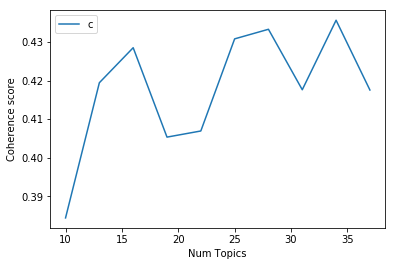

Num Topics = 10  has Coherence Value of 0.3844
Num Topics = 13  has Coherence Value of 0.4194
Num Topics = 16  has Coherence Value of 0.4285
Num Topics = 19  has Coherence Value of 0.4053
Num Topics = 22  has Coherence Value of 0.4069
Num Topics = 25  has Coherence Value of 0.4308
Num Topics = 28  has Coherence Value of 0.4333
Num Topics = 31  has Coherence Value of 0.4176
Num Topics = 34  has Coherence Value of 0.4356
Num Topics = 37  has Coherence Value of 0.4175


In [25]:
# Show graph
start=10; limit=40; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [26]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)



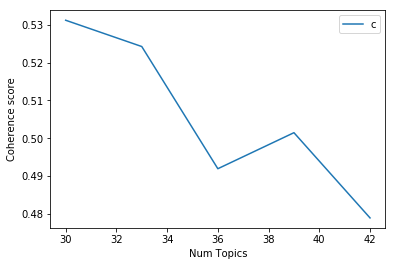

Num Topics = 30  has Coherence Value of 0.5312
Num Topics = 33  has Coherence Value of 0.5242
Num Topics = 36  has Coherence Value of 0.4919
Num Topics = 39  has Coherence Value of 0.5015
Num Topics = 42  has Coherence Value of 0.4789


In [27]:
# print graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df:   
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  
> Num Topics = 30  has Coherence Value of 0.5535  
> Num Topics = 33  has Coherence Value of 0.4843  
> Num Topics = 36  has Coherence Value of 0.4783  
> Num Topics = 39  has Coherence Value of 0.4902  
> Num Topics = 42  has Coherence Value of 0.4779  
      
  As expected (and unexplained) LDA Model performs better   
  than the LDA multicore model with identical parameters   



# Attempting high score: Topics: 30, chunks: 50k, passes=20

> New Best Model? Yes  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238   

added 'new' as stopword, coherence dropped to 0.603. Decision reversed.


In [28]:
def run_model(topics=30, chunksize=50000, passes=50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=topics, 
                                               random_state=100,
                                               chunksize=chunksize,    # chunksize = number of docs to be used in each training chunk
                                               passes=passes,
                                               per_word_topics=True)

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis,'vis_' + str(topics) + '.html')
    vis
    return;



In [29]:
#run_model(topics=30, chunksize=50000, passes=20)

# Attempting new high score: Topics: 30, chunks: 50k, passes=50

> New Best Model? Yes. Marginal improvement in Coherence Score (0.0034) by increasing from 20 to 50 passes.  
> Runtime: unclocked.   
> Perplexity: -8.609     
> Coherence Score: 0.6272     

added stopword 'new' and coherence decreased to 0.6078. Decision reversed.

In [30]:
run_model(topics=30, chunksize=50000, passes=50)


Perplexity:  -8.60946785470689

Coherence Score:  0.6272157809690225


# trying same best model, separate random state (100 -> 200)
Before:  
> Runtime: 3hrs 25 minutes (12,209 seconds).   
> Perplexity: -8.609     
> Coherence Score: 0.6272    
 
After (random state changed to 200):  
> Runtime: 2hrs 15min (8,111 seconds)  
> Perplexity: -8.603    
> Coherence Score: 0.611      

Results: Similar score, no improvement.

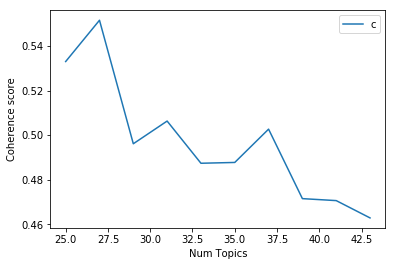

Num Topics = 25  has Coherence Value of 0.533
Num Topics = 27  has Coherence Value of 0.5516
Num Topics = 29  has Coherence Value of 0.4961
Num Topics = 31  has Coherence Value of 0.5063
Num Topics = 33  has Coherence Value of 0.4874
Num Topics = 35  has Coherence Value of 0.4877
Num Topics = 37  has Coherence Value of 0.5027
Num Topics = 39  has Coherence Value of 0.4715
Num Topics = 41  has Coherence Value of 0.4706
Num Topics = 43  has Coherence Value of 0.4628


In [31]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=25, limit=45, step=2)

start=25; limit=45; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [ ]:
run_model(topics=12, chunksize=40000, passes=50)

In [ ]:
run_model(topics=15, chunksize=40000, passes=50)

In [ ]:
run_model(topics=17, chunksize=40000, passes=50)

In [32]:
run_model(topics=20, chunksize=40000, passes=50)


Perplexity:  -8.6538246200915

Coherence Score:  0.5967567636771302


In [33]:
run_model(topics=23, chunksize=40000, passes=50)


Perplexity:  -8.650769634432207

Coherence Score:  0.6016374020994492


In [34]:
run_model(topics=25, chunksize=50000, passes=50)


Perplexity:  -8.622156314066975

Coherence Score:  0.5991849708042652


In [35]:
run_model(topics=28, chunksize=50000, passes=50)


Perplexity:  -8.617545956891613

Coherence Score:  0.5800842758360009


In [36]:
run_model(topics=32, chunksize=50000, passes=50)


Perplexity:  -8.61170872788705

Coherence Score:  0.5840451124637469


In [ ]:
run_model(topics=35, chunksize=50000, passes=50)


Perplexity:  -8.620173389217138

Coherence Score:  0.5779573624659029


In [ ]:
run_model(topics=37, chunksize=40000, passes=50)